In [104]:
library(tidyverse)
library(repr)
library(tidymodels)

In [105]:
tennis_data = read_csv("https://drive.google.com/uc?export=download&id=1fOQ8sy_qMkQiQEAO6uFdRX4tLI8EpSTn") %>%
    select(tourney_level, winner_ht, loser_ht, winner_age, loser_age, minutes) %>%
    na.omit()

Warning message:
“Missing column names filled in: 'X1' [1]”
Parsed with column specification:
cols(
  .default = col_double(),
  tourney_id = col_character(),
  tourney_name = col_character(),
  surface = col_character(),
  tourney_level = col_character(),
  winner_seed = col_character(),
  winner_entry = col_character(),
  winner_name = col_character(),
  winner_hand = col_character(),
  winner_ioc = col_character(),
  loser_seed = col_character(),
  loser_entry = col_character(),
  loser_name = col_character(),
  loser_hand = col_character(),
  loser_ioc = col_character(),
  score = col_character(),
  round = col_character()
)

See spec(...) for full column specifications.



In [106]:
tennis_split = initial_split(tennis_data, prop = .75, strata = tourney_level)  
tennis_train = training(tennis_split)   
tennis_test = testing(tennis_split)

In [107]:
tennis_summary_num = tennis_train %>%
    group_by(tourney_level) %>%
    summarize(n = n())

tennis_summary_length = tennis_train %>%
    group_by(tourney_level) %>%
    summarize(average_length = mean(minutes))


tennis_summary_winner_height = tennis_train %>%
    group_by(tourney_level) %>%
    summarize(average_winner_height = mean(winner_ht))

tennis_summary_loser_height = tennis_train %>%
    group_by(tourney_level) %>%
    summarize(average_loser_height = mean(loser_ht))

tennis_summary_winner_age = tennis_train %>%
    group_by(tourney_level) %>%
    summarize(average_winner_age = mean(winner_age))

tennis_summary_loser_age = tennis_train %>%
    group_by(tourney_level) %>%
    summarize(average_loser_age = mean(loser_age))

summary_table <- tennis_summary_num %>% 
    inner_join(tennis_summary_length) %>%
    inner_join(tennis_summary_winner_height) %>% 
    inner_join(tennis_summary_loser_height) %>% 
    inner_join(tennis_summary_winner_age) %>% 
    inner_join(tennis_summary_loser_age)

summary_table

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

Joining, by = "tourney_level"

Joining, by = "tourney_level"

Joining, by = "tourney_level"

Joining, by = "tourney_level"

Joining, by = "tourney_level"



tourney_level,n,average_length,average_winner_height,average_loser_height,average_winner_age,average_loser_age
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A,1107,99.03884,186.3568,185.8898,29.67199,30.04157
D,53,145.84906,183.9245,184.2830,29.32657,29.47839
F,18,91.55556,186.1111,190.5000,29.61640,29.71770
G,446,150.23543,187.2758,186.0224,29.93043,29.86054
M,526,101.27947,187.2909,186.3099,29.55240,29.86884


In [108]:
plot_data <- tennis_train %>% 
    mutate(row = row_number()) %>%
    pivot_longer(winner_ht:loser_age, names_to = c("player_type", "category"), names_pattern = "([A-Za-z]+)_([A-Za-z]+)", values_to = "value") %>%
    mutate(category = as_factor(category)) %>% 
    mutate(player_type = as_factor(player_type)) %>% 
    pivot_wider(names_from = category, values_from = value) %>% 
    select(-row)

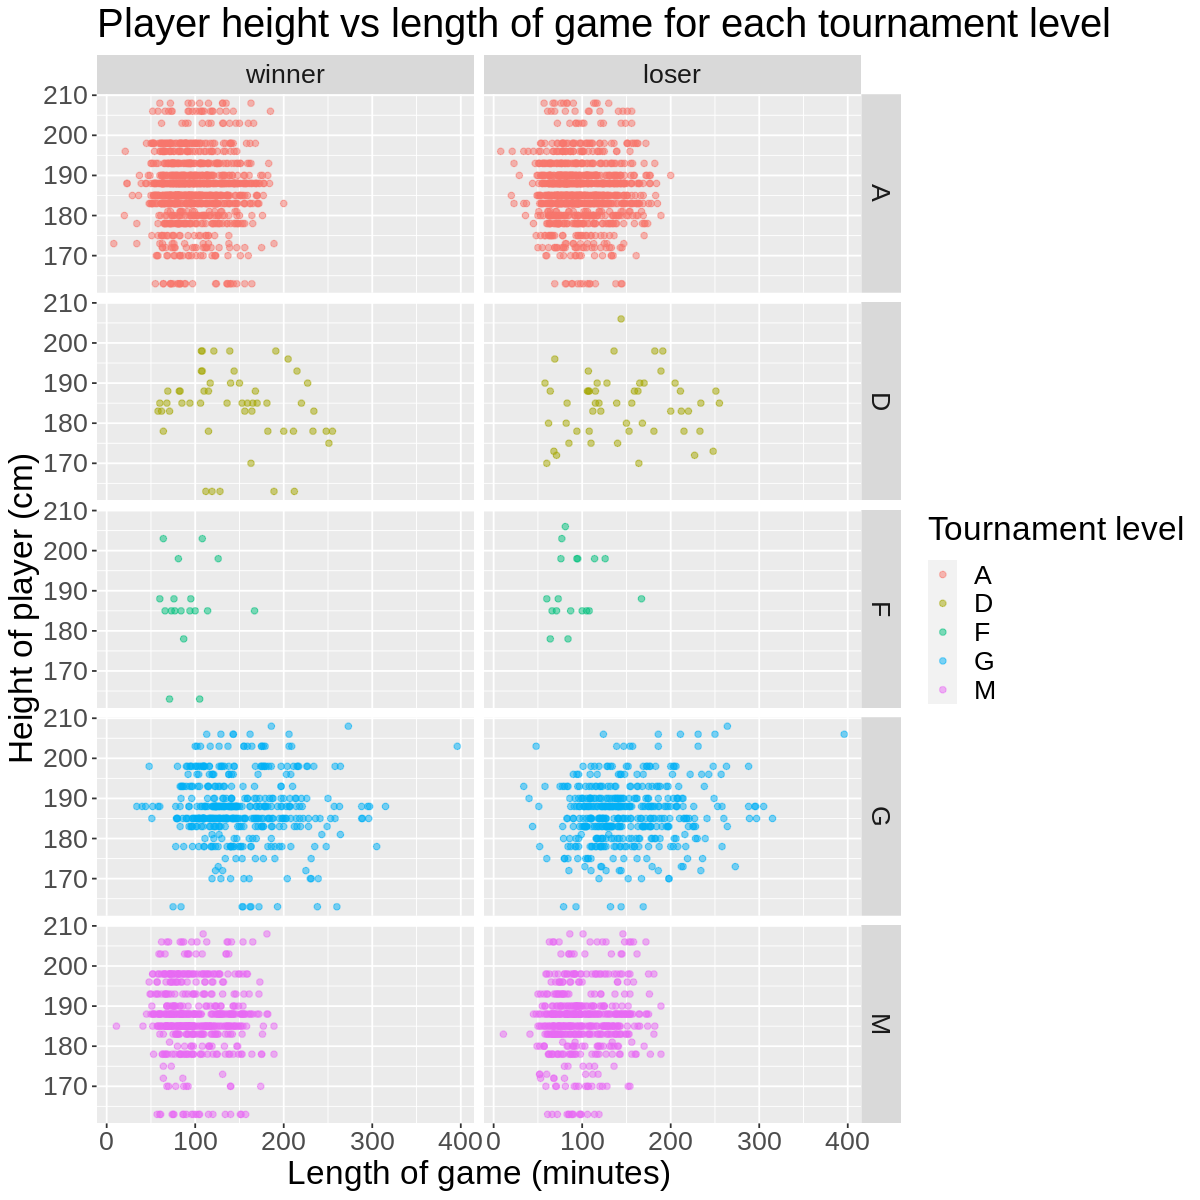

In [109]:
options(repr.plot.width = 10, repr.plot.height = 10)

tennis_plot_height = plot_data %>%
    ggplot(aes(x = minutes, 
               y = ht, 
               colour = tourney_level)) +
    geom_point(alpha = 0.5) + 
    labs(x = "Length of game (minutes)",
         y = "Height of player (cm)",
         colour = "Tournament level",
         title = "Player height vs length of game for each tournament level") +
    facet_grid(tourney_level ~ player_type) +
    theme(text = element_text(size = 20))

tennis_plot_height

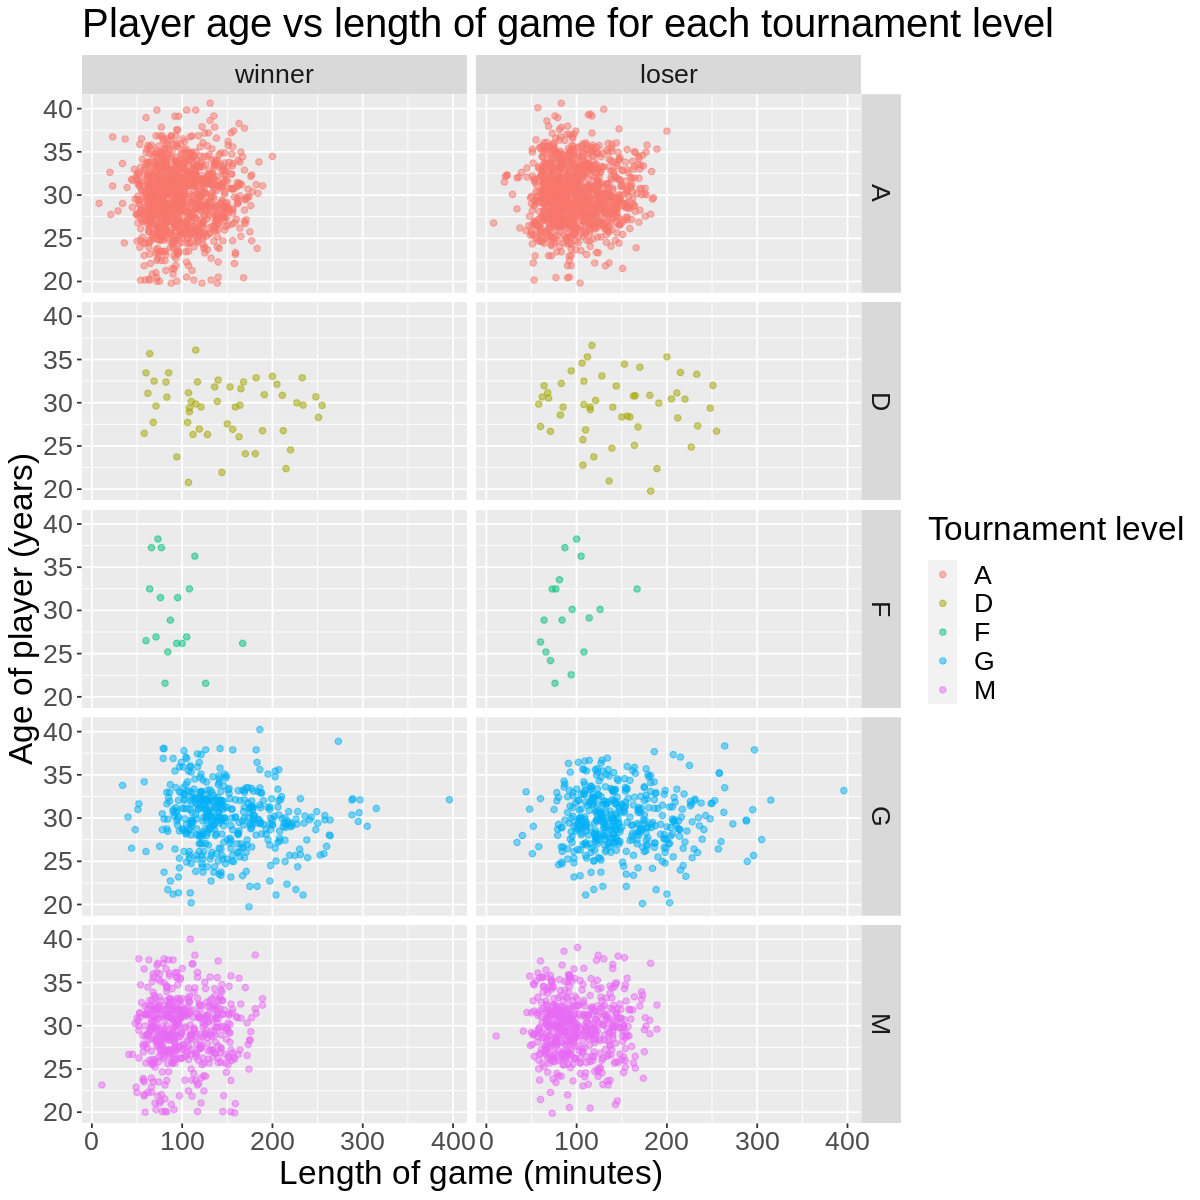

In [110]:
options(repr.plot.width = 10, repr.plot.height = 10)

tennis_plot_age = plot_data %>%
    ggplot(aes(x = minutes, 
               y = age, 
               colour = tourney_level)) +
    geom_point(alpha = 0.5) + 
    labs(x = "Length of game (minutes)",
         y = "Age of player (years)",
         colour = "Tournament level",
         title = "Player age vs length of game for each tournament level") +
    facet_grid(tourney_level ~ player_type) +
    theme(text = element_text(size = 20))

tennis_plot_age